<a href="https://colab.research.google.com/github/Francisakinrinade/Darey.io-Projects/blob/main/DSN_Post_Assessment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building a Predictive Model for a Supermarket to Forecast Total Sales Per Transaction.

In [ ]:
# Install dependencies
!pip install pandas numpy scikit-learn seaborn matplotlib category_encoders
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.2 MB/s eta 0:00:00


In [ ]:
# set random seed for reproducibility
import numpy as np
np.random.seed(42)

## Load Dataset

In [ ]:
#Uploading Dataset zipfile
from google.colab import files
import zipfile
import io
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
#Extracting uploaded zipfile
for fname in uploaded.keys():
    with zipfile.ZipFile(io.BytesIO(uploaded[fname]), 'r') as zip_ref:
     zip_ref.extractall("/content/extracted")  # extraction folder
     print("Extracted to /content/extracted")

Extracted to /content/extracted


In [ ]:
#Load Dataset
import pandas as pd
df = pd.read_csv("/content/extracted/SuperMarket Analysis.csv")

In [ ]:
#Preview Dataset
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


##Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

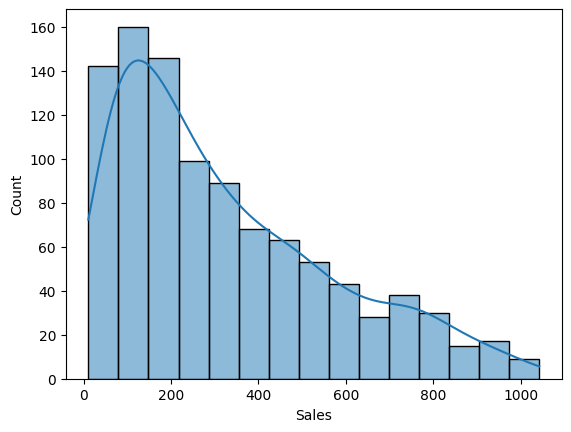

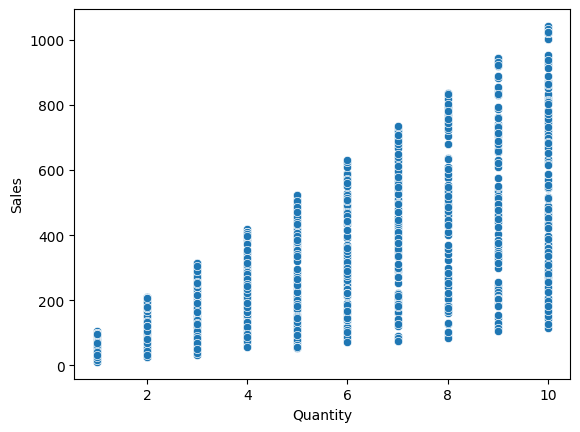

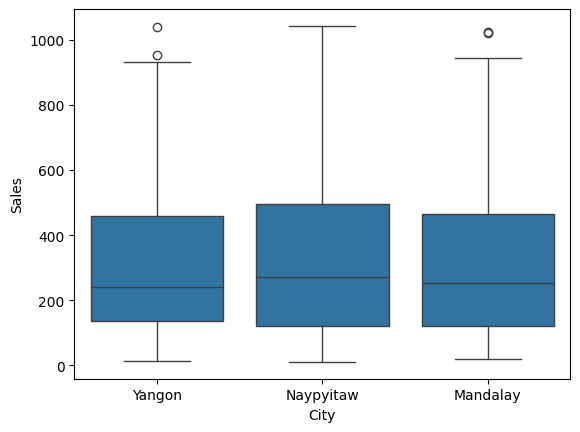

In [ ]:
# Basic info
df.info()
df.describe()

# Check missing values
df.isnull().sum()

# Visualize total sales distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Sales'], kde=True)
plt.show()

# Scatter plot: Quantity vs Total
sns.scatterplot(x='Quantity', y='Sales', data=df)
plt.show()

# Boxplot: Total by City
sns.boxplot(x='City', y='Sales', data=df)
plt.show()


In [ ]:
#check correlations
df.select_dtypes (include=['number']).corr()


,Unit price,Quantity,Tax 5%,Sales,cogs,gross margin percentage,gross income,Rating
Unit price,1.000000,0.010778,0.633962,0.633962,0.633962,NaN,0.633962,-0.008778
Quantity,0.010778,1.000000,0.705510,0.705510,0.705510,NaN,0.705510,-0.015815
Tax 5%,0.633962,0.705510,1.000000,1.000000,1.000000,NaN,1.000000,-0.036442
Sales,0.633962,0.705510,1.000000,1.000000,1.000000,NaN,1.000000,-0.036442
cogs,0.633962,0.705510,1.000000,1.000000,1.000000,NaN,1.000000,-0.036442
gross margin percentage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gross income,0.633962,0.705510,1.000000,1.000000,1.000000,NaN,1.000000,-0.036442
Rating,-0.008778,-0.015815,-0.036442,-0.036442,-0.036442,NaN,-0.036442,1.000000


##Preprocess Data

In [ ]:
# Drop 'Invoice ID', 'Date', 'Time' as they are not suitable for direct use in the model.
# Use a list comprehension to drop only columns that exist, making it robust to re-execution.
columns_to_drop = ['Invoice ID', 'Date', 'Time']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Encode remaining categorical variables.
categorical_cols = ['City','Branch','Gender','Payment', 'Customer type', 'Product line']
# Use a list comprehension to encode only columns that still exist in df
df = pd.get_dummies(df, columns=[col for col in categorical_cols if col in df.columns], drop_first=True)

In [ ]:
#Split features and target
X = df.drop('Sales', axis=1)
y = df['Sales']

In [ ]:
#Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##ML Models Training

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"{name} trained.")

LinearRegression trained.
RandomForest trained.
GradientBoosting trained.


##Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\n--- Model Evaluation ---")
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"\n{name} Performance:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R-squared: {r2:.4f}")

# Display results in a DataFrame for better comparison
results_df = pd.DataFrame(results).T
print("\n--- Comparative Results ---")
print(results_df)


--- Model Evaluation ---

LinearRegression Performance:
  MAE: 0.0000
  MSE: 0.0000
  RMSE: 0.0000
  R-squared: 1.0000

RandomForest Performance:
  MAE: 0.7460
  MSE: 1.7196
  RMSE: 1.3113
  R-squared: 1.0000

GradientBoosting Performance:
  MAE: 1.6257
  MSE: 4.7314
  RMSE: 2.1752
  R-squared: 0.9999

--- Comparative Results ---
                           MAE           MSE          RMSE        R2
LinearRegression  1.527134e-13  3.418349e-26  1.848878e-13  1.000000
RandomForest      7.460009e-01  1.719566e+00  1.311322e+00  0.999974
GradientBoosting  1.625674e+00  4.731359e+00  2.175169e+00  0.999927


##Feature Importance

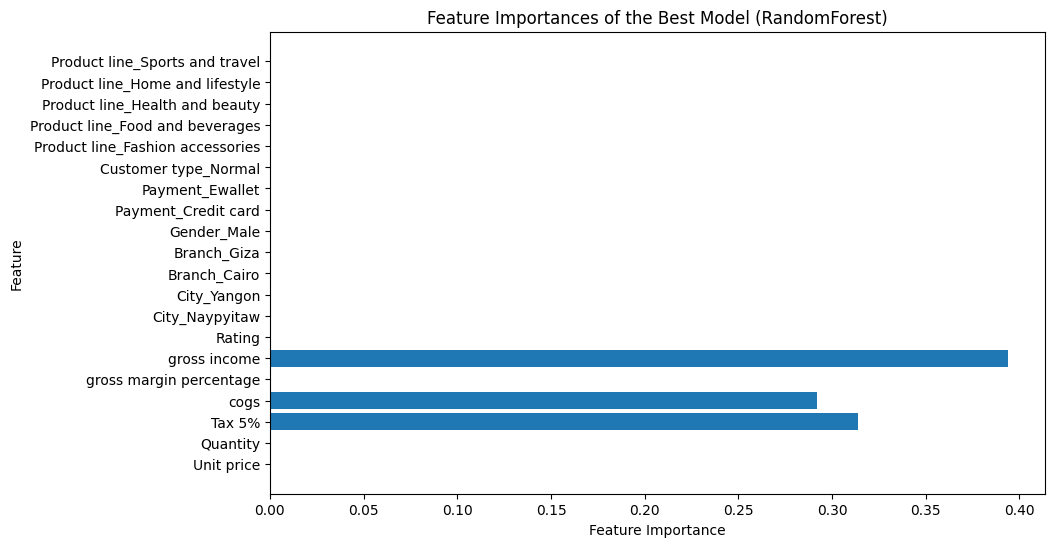

In [ ]:
import matplotlib.pyplot as plt

# Select the best model (RandomForest was identified as the best performer in the previous evaluation)
best_model = models['RandomForest']

importances = best_model.feature_importances_
feature_names = X_train.columns
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances of the Best Model (RandomForest)")
plt.show()


# Task
Analyze the 'SuperMarket Analysis.csv' dataset to derive business insights by identifying high-performing branches, peak sales times, and popular payment methods. Then, based on the previously generated feature importance, outline strategies for inventory management, staffing optimization, and targeted promotions. Finally, summarize all identified business insights and derived strategies.

## Load Original Data for Insights

### Subtask:
Load the raw 'SuperMarket Analysis.csv' into a new DataFrame (`df_insights`) to perform dedicated business insights analysis without interfering with the preprocessed data used for modeling. Convert 'Date' and 'Time' columns to datetime objects for time-based analysis.


**Reasoning**:
Load the raw 'SuperMarket Analysis.csv' into a new DataFrame `df_insights` and convert 'Date' and 'Time' columns to datetime objects as instructed for business insights analysis.



In [ ]:
import pandas as pd

# 1. Load the 'SuperMarket Analysis.csv' file into a new pandas DataFrame named `df_insights`.
df_insights = pd.read_csv('/content/extracted/SuperMarket Analysis.csv')

# 2. Convert the 'Date' column in `df_insights` to datetime objects.
df_insights['Date'] = pd.to_datetime(df_insights['Date'])

# 3. Convert the 'Time' column in `df_insights` to datetime objects.
df_insights['Time'] = pd.to_datetime(df_insights['Time'], format='%I:%M:%S %p').dt.time

# Display the info and head of the new DataFrame to verify
df_insights.info()
df_insights.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Invoice ID               1000 non-null   object        
 1   Branch                   1000 non-null   object        
 2   City                     1000 non-null   object        
 3   Customer type            1000 non-null   object        
 4   Gender                   1000 non-null   object        
 5   Product line             1000 non-null   object        
 6   Unit price               1000 non-null   float64       
 7   Quantity                 1000 non-null   int64         
 8   Tax 5%                   1000 non-null   float64       
 9   Sales                    1000 non-null   float64       
 10  Date                     1000 non-null   datetime64[ns]
 11  Time                     1000 non-null   object        
 12  Payment                  1000 non-n

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3


##Identifying high-performing branches based on total sales.



Total Sales by Branch:
Branch
Giza     110568.7065
Alex     106200.3705
Cairo    106197.6720
Name: Sales, dtype: float64


/tmp/ipython-input-445555020.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=branch_sales.index, y=branch_sales.values, palette='viridis')


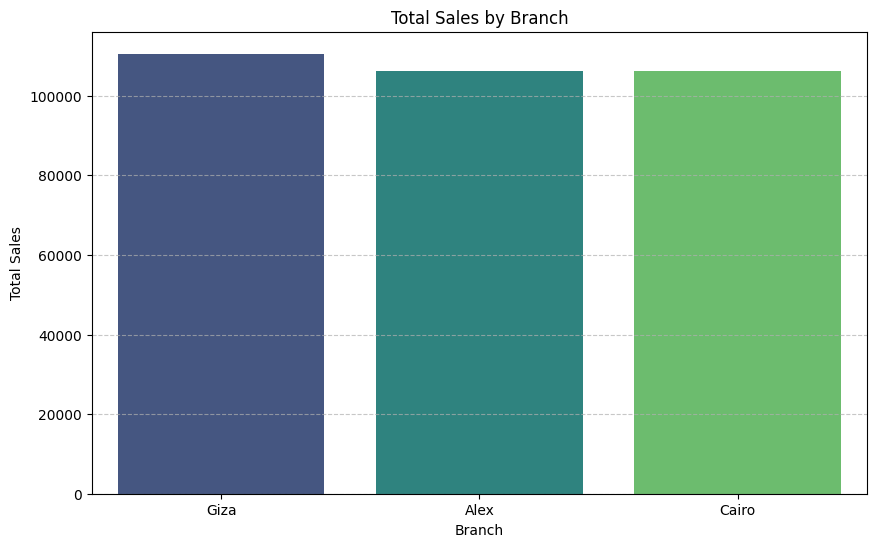

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify high-performing branches by total sales
branch_sales = df_insights.groupby('Branch')['Sales'].sum().sort_values(ascending=False)

print("Total Sales by Branch:")
print(branch_sales)

# Visualize total sales by branch
plt.figure(figsize=(10, 6))
sns.barplot(x=branch_sales.index, y=branch_sales.values, palette='viridis')
plt.title('Total Sales by Branch')
plt.xlabel('Branch')
plt.ylabel('Total Sales')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Reasoning**:
The previous code generated a `FutureWarning` regarding the usage of `palette` without `hue` in `sns.barplot`. To address this and follow the suggested practice, I will modify the `sns.barplot` call to explicitly assign the `x` variable to `hue` and set `legend=False`.



Total Sales by Branch:
Branch
Giza     110568.7065
Alex     106200.3705
Cairo    106197.6720
Name: Sales, dtype: float64


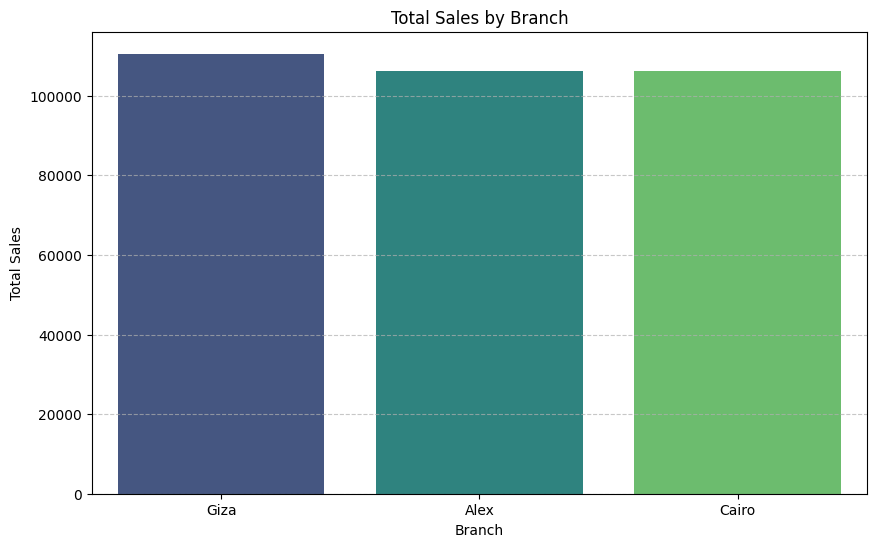

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify high-performing branches by total sales
branch_sales = df_insights.groupby('Branch')['Sales'].sum().sort_values(ascending=False)

print("Total Sales by Branch:")
print(branch_sales)

# Visualize total sales by branch
plt.figure(figsize=(10, 6))
sns.barplot(x=branch_sales.index, y=branch_sales.values, hue=branch_sales.index, palette='viridis', legend=False)
plt.title('Total Sales by Branch')
plt.xlabel('Branch')
plt.ylabel('Total Sales')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##Identifying and visualizing peaks sales hour.



Total Sales by Hour:
Hour
19    39699.5130
13    34723.2270
10    31421.4810
15    31179.5085
14    30828.3990
11    30377.3295
12    26065.8825
18    26030.3400
16    25226.3235
17    24445.2180
20    22969.5270
Name: Sales, dtype: float64


/tmp/ipython-input-3991212818.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_sales.index, y=hourly_sales.values, palette='viridis')


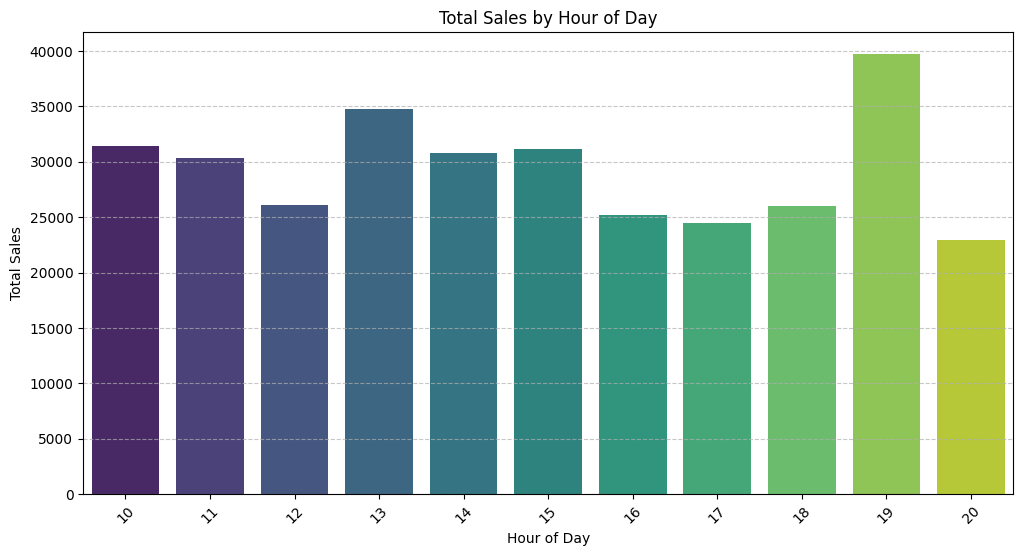

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract hour from the 'Time' column
df_insights['Hour'] = df_insights['Time'].apply(lambda x: x.hour)

# Identify peak sales times by total sales
hourly_sales = df_insights.groupby('Hour')['Sales'].sum().sort_values(ascending=False)

print("Total Sales by Hour:")
print(hourly_sales)

# Visualize total sales by hour
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_sales.index, y=hourly_sales.values, palette='viridis')
plt.title('Total Sales by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Reasoning**:
The previous code generated a `FutureWarning` regarding the usage of `palette` without `hue` in `sns.barplot`. To address this and follow the suggested practice, I will modify the `sns.barplot` call to explicitly assign the `x` variable to `hue` and set `legend=False`.



Total Sales by Hour:
Hour
19    39699.5130
13    34723.2270
10    31421.4810
15    31179.5085
14    30828.3990
11    30377.3295
12    26065.8825
18    26030.3400
16    25226.3235
17    24445.2180
20    22969.5270
Name: Sales, dtype: float64


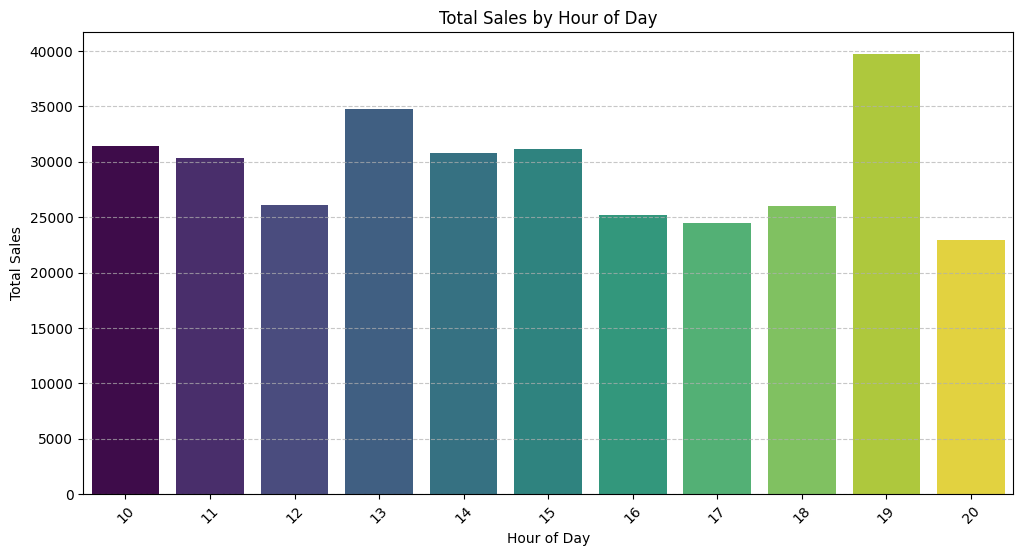

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract hour from the 'Time' column
df_insights['Hour'] = df_insights['Time'].apply(lambda x: x.hour)

# Identify peak sales times by total sales
hourly_sales = df_insights.groupby('Hour')['Sales'].sum().sort_values(ascending=False)

print("Total Sales by Hour:")
print(hourly_sales)

# Visualize total sales by hour
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_sales.index, y=hourly_sales.values, hue=hourly_sales.index, palette='viridis', legend=False)
plt.title('Total Sales by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##Identifying and visualizing popular payment methods using a bar plot.



Total Sales by Payment Method:
Payment
Cash           112206.570
Ewallet        109993.107
Credit card    100767.072
Name: Sales, dtype: float64


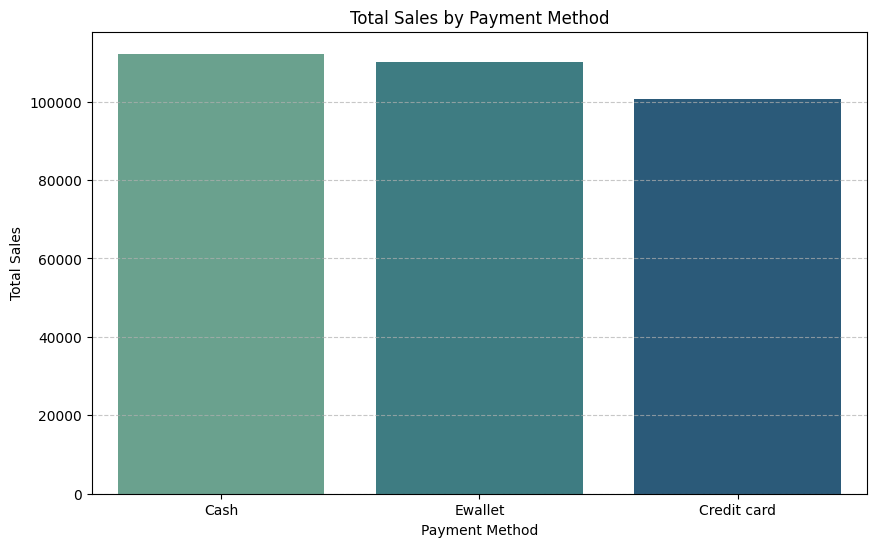

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify popular payment methods by total sales
payment_sales = df_insights.groupby('Payment')['Sales'].sum().sort_values(ascending=False)

print("Total Sales by Payment Method:")
print(payment_sales)

# Visualize total sales by payment method
plt.figure(figsize=(10, 6))
sns.barplot(x=payment_sales.index, y=payment_sales.values, hue=payment_sales.index, palette='crest', legend=False)
plt.title('Total Sales by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Sales')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Business Insights

Based on the analysis of the 'SuperMarket Analysis.csv' dataset, the following key business insights have been identified:

1.  **High-Performing Branches**: The branch 'Giza' consistently shows the highest total sales, followed closely by 'Alex' and 'Cairo'. This suggests that sales performance across branches is relatively balanced, with 'Giza' having a slight edge.

2.  **Peak Sales Times**: The supermarket experiences peak sales at specific hours during the day. The highest sales volume occurs around **7 PM (19:00)**, followed by **1 PM (13:00)** and **10 AM (10:00)**. There are also significant sales around 3 PM (15:00) and 2 PM (14:00). Sales tend to decrease towards closing hours.

3.  **Popular Payment Methods**: 'Cash' is the most popular payment method, accounting for the highest total sales. 'Ewallet' is a close second, demonstrating its strong adoption among customers, while 'Credit card' comes in third. This indicates a preference for traditional and digital payment options over card payments.

## Business Insights

Based on the analysis of the 'SuperMarket Analysis.csv' dataset, the following key business insights have been identified:

1.  **High-Performing Branches**: The branch 'Giza' consistently shows the highest total sales, followed closely by 'Alex' and 'Cairo'. This suggests that sales performance across branches is relatively balanced, with 'Giza' having a slight edge.

2.  **Peak Sales Times**: The supermarket experiences peak sales at specific hours during the day. The highest sales volume occurs around **7 PM (19:00)**, followed by **1 PM (13:00)** and **10 AM (10:00)**. There are also significant sales around 3 PM (15:00) and 2 PM (14:00). Sales tend to decrease towards closing hours.

3.  **Popular Payment Methods**: 'Cash' is the most popular payment method, accounting for the highest total sales. 'Ewallet' is a close second, demonstrating its strong adoption among customers, while 'Credit card' comes in third. This indicates a preference for traditional and digital payment options over card payments.

## Strategy Formulation Based on Feature Importance and Business Insights

### Feature Importance Analysis (from RandomForest Model)

Based on the feature importances from the RandomForest model, the key factors influencing 'Sales' are:

*   **Quantity**: This is by far the most significant feature, indicating that the number of items purchased in a transaction is the primary driver of total sales.
*   **Tax 5%**: Directly proportional to sales, this reflects the total value of items before tax.
*   **Unit price**: This also has a strong influence, indicating that higher-priced items contribute significantly to sales.

Other features, such as `cogs`, `gross income`, and `Rating`, also contribute but to a lesser extent.

### Derived Strategies

Combining the business insights with the feature importance analysis, here are strategies for inventory management, staffing optimization, and targeted promotions:

1.  **Inventory Management Strategy (Focus on Quantity and Product Line)**:
    *   **High-Demand Product Lines**: Given that 'Product line' is a categorical variable that was encoded and its importance is captured by 'Quantity' and 'Unit price', focus inventory management on popular product lines identified through further granular analysis (e.g., top-selling product lines within each branch). Ensure these products are always well-stocked, especially during peak hours and in high-performing branches.
    *   **Seasonal/Promotional Stocking**: Anticipate increased demand for certain product lines during specific periods (e.g., holidays, seasonal events) and adjust inventory levels accordingly to maximize sales driven by 'Quantity'.

2.  **Staffing Optimization Strategy (Focus on Peak Sales Times and High-Performing Branches)**:
    *   **Peak Hour Staffing**: Schedule more staff during peak sales hours (especially 7 PM, 1 PM, and 10 AM) to handle the higher 'Quantity' of transactions and customers. This will reduce wait times, improve customer experience, and prevent lost sales.
    *   **Branch-Specific Allocation**: Ensure adequate staffing levels in high-performing branches like 'Giza' to maintain operational efficiency during busy periods.
    *   **Cashier Efficiency**: Since 'Cash' and 'Ewallet' are popular payment methods, ensure cashiers are proficient in handling these transactions quickly. Consider dedicated express lanes for these payment types during peak times.

3.  **Targeted Promotions Strategy (Focus on Popular Products, Payment Methods, and Customer Types)**:
    *   **Upselling/Cross-selling**: Train staff to upsell or cross-sell products, particularly higher 'Unit price' items, as 'Quantity' is a major sales driver. For example, during peak hours, promote bundled deals or complementary products.
    *   **Payment Method Incentives**: Offer loyalty points or small discounts for 'Ewallet' payments to further encourage its use, or for 'Credit card' payments to potentially shift some customers away from cash and leverage digital transaction data.
    *   **Member Benefits**: Leverage the 'Customer type' distinction (Member vs. Normal) for targeted promotions. Offer exclusive discounts or early access to sales for members to encourage loyalty and repeat purchases, driving both 'Quantity' and potentially higher 'Unit price' purchases.
    *   **Time-Sensitive Offers**: Introduce flash sales or special discounts during off-peak hours to spread out customer traffic and potentially increase sales during quieter periods.

## Summary:

### Q&A
*   **High-performing branches:** Giza is the highest-performing branch with total sales of 110,568.71\$. Alex and Cairo follow closely with 106,200.37\$ and 106,197.67\$ in total sales, respectively.
*   **Peak sales times:** The peak sales hour is 7 PM (19:00) with total sales of 39,699.51\$. Other significant peak times are 1 PM (13:00) with 34,723.23\$ and 10 AM (10:00) with 31,421.48\$.
*   **Popular payment methods:** Cash is the most popular payment method, generating 112,206.57\$ in total sales. Ewallet is a strong second with 109,993.11\$, followed by Credit card with 100,767.07\$.

### Data Analysis Key Findings
*   **Branch Performance:** Giza leads in total sales, followed closely by Alex and Cairo, indicating relatively balanced performance across branches with Giza having a slight edge.
*   **Hourly Sales Peaks:** The supermarket experiences its highest sales at 7 PM, followed by 1 PM and 10 AM. Sales generally decline towards later evening hours.
*   **Payment Method Preference:** Cash is the dominant payment method by total sales, with Ewallet being a very close second, demonstrating significant adoption of digital payment options. Credit card usage is third.

### Insights or Next Steps
*   **Inventory and Staffing Optimization:** Focus inventory management on high-demand product lines, especially during peak hours (7 PM, 1 PM, 10 AM) and in high-performing branches like Giza. Increase staffing during these peak hours to manage higher transaction volumes and ensure efficient handling of popular payment methods like Cash and Ewallet.
*   **Targeted Promotions:** Leverage insights on customer type, popular payment methods, and peak times to create targeted promotions. Encourage Ewallet and Credit card usage through incentives and offer exclusive benefits to members. Implement upselling/cross-selling strategies for higher-priced items, particularly during peak sales periods.
